### Walgreen Stock Price Prediction

In [68]:
## import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


**1. Loading the data from walgreen_data.csv file**

In [69]:
df = pd.read_csv('Walgreen_Stock.csv')

In [70]:
df.shape

(10468, 7)

In [71]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


**2. Data Preprocessing**

In [72]:
## Finding Null values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [74]:
## Converting the date column into datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       10468 non-null  datetime64[ns]
 1   Open       10468 non-null  float64       
 2   High       10468 non-null  float64       
 3   Low        10468 non-null  float64       
 4   Close      10468 non-null  float64       
 5   Adj Close  10468 non-null  float64       
 6   Volume     10468 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 572.6 KB


In [76]:
## making date column as index
df.set_index('Date', inplace=True)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10468 entries, 1980-12-12 to 2022-06-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10468 non-null  float64
 1   High       10468 non-null  float64
 2   Low        10468 non-null  float64
 3   Close      10468 non-null  float64
 4   Adj Close  10468 non-null  float64
 5   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 572.5 KB


In [78]:
df.drop(df[df.index < pd.to_datetime('2018-08-15')].index, inplace=True)

In [79]:
df.shape

(968, 6)

In [80]:
## converting sequential data by sorting based on date
df = df.sort_index()

In [81]:
## Data Normalization 
scaler = MinMaxScaler()
scaler_values = scaler.fit_transform(df[df.columns])

In [82]:
scaler_values

array([[0.11122856, 0.11094806, 0.11546094, 0.11615602, 0.11076474,
        0.19255117],
       [0.11554199, 0.1161866 , 0.12092676, 0.12141334, 0.11581483,
        0.1893637 ],
       [0.1184233 , 0.12325096, 0.12386855, 0.12868482, 0.12279981,
        0.26123317],
       ...,
       [0.67033785, 0.68875841, 0.67302609, 0.68196635, 0.68672669,
        0.13108091],
       [0.65526647, 0.65497234, 0.65130202, 0.6453017 , 0.65022031,
        0.17411714],
       [0.641559  , 0.65968194, 0.65666343, 0.65554323, 0.66041764,
        0.24154626]], shape=(968, 6))

In [83]:
## the above normalized values are in numpy array format, converting them into dataframe
df_scaled = pd.DataFrame(scaler_values, columns=df.columns, index=df.index)
df_scaled.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-15,0.111229,0.110948,0.115461,0.116156,0.110765,0.192551
2018-08-16,0.115542,0.116187,0.120927,0.121413,0.115815,0.189364
2018-08-17,0.118423,0.123251,0.123869,0.128685,0.122800,0.261233
2018-08-20,0.126368,0.125350,0.127263,0.125066,0.119324,0.207908
2018-08-21,0.124152,0.121954,0.125383,0.124349,0.118635,0.165078


**3. Plotting the Columns**

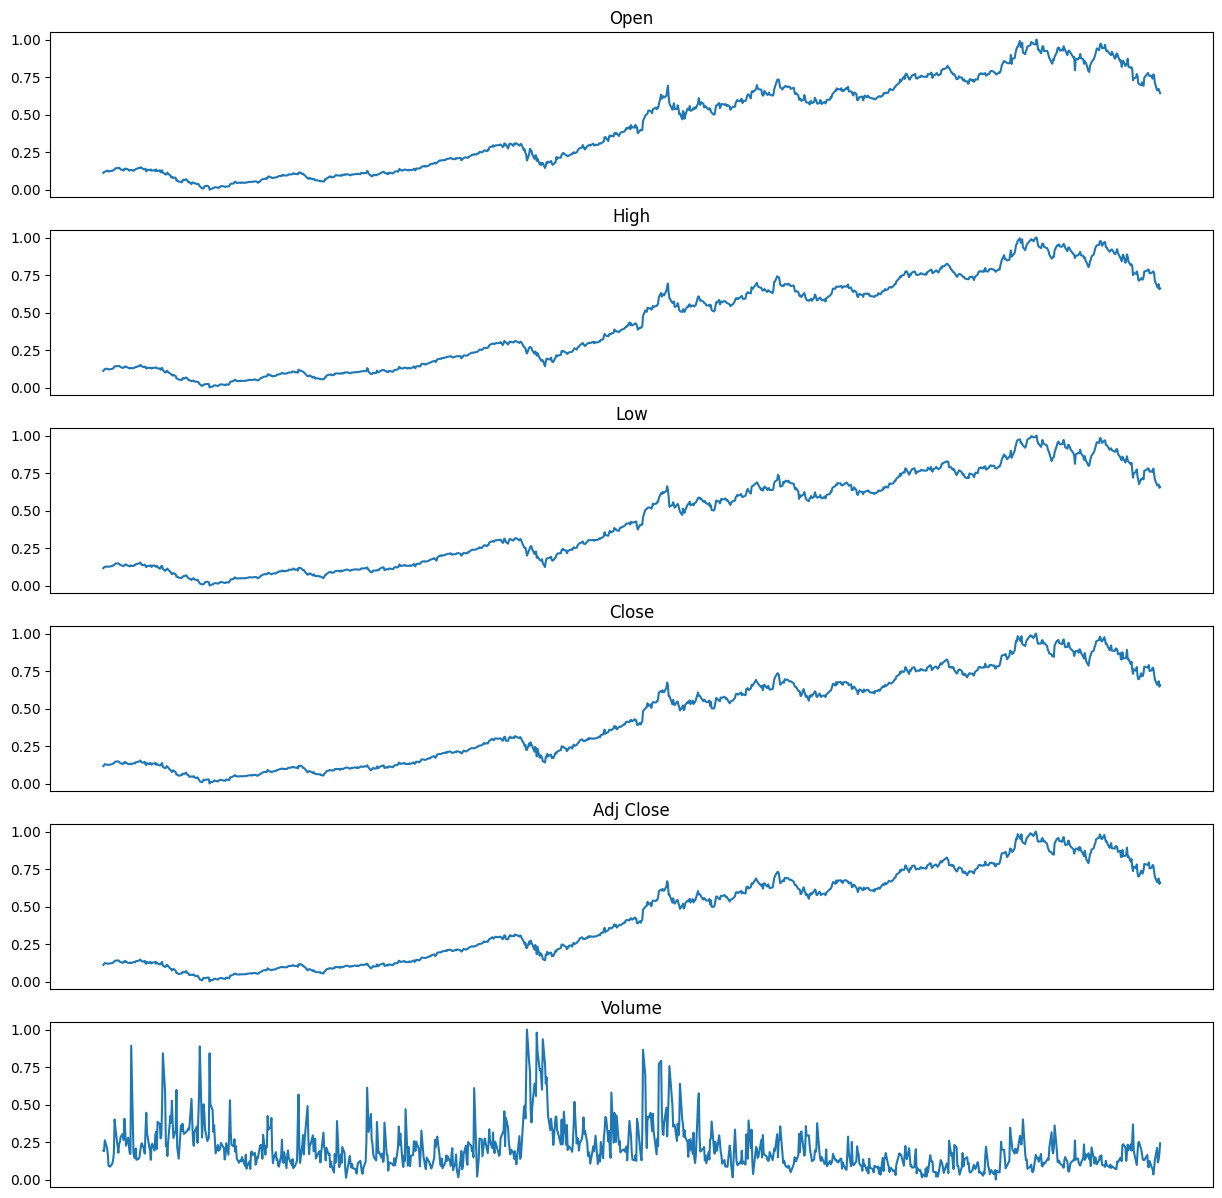

In [84]:
plt.rcParams['figure.figsize'] = (15,15)
figure, axes = plt.subplots(6)

for ax, col in zip(axes, df_scaled.columns):
    ax.plot(df_scaled[col])
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)

**4. Creating the sliding window sequences**

In [85]:
## [1,2,3,4.... 10]
# window_size = 3
# [1,2,3] => [4]
# [2,3,4] => [5]
# [3,4,5] => [6]

In [86]:
def create_sequence(data,window_size):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i].values)
    return np.array(X), np.array(y)

In [87]:
X, y = create_sequence(df_scaled, window_size=60)

In [88]:
X.shape, y.shape

((908, 60, 6), (908, 6))

**5. Train - Test Split**

In [89]:
X_train,X_text,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_text.shape, y_train.shape, y_test.shape

((726, 60, 6), (182, 60, 6), (726, 6), (182, 6))

**6. Building LSTM model**

In [90]:
model = keras.Sequential([
# Adding the first LSTM layer and some Dropout regularisation
keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
keras.layers.Dropout(0.3),

# Adding the Second LSTM layer and some Dropout regularisation
keras.layers.LSTM(units=50, return_sequences=True),
keras.layers.Dropout(0.3),

# Adding the Third LSTM layer and some Dropout regularisation
keras.layers.LSTM(units=50, return_sequences=False),
keras.layers.Dropout(0.3),

# Adding the output layer
keras.layers.Dense(units=y_train.shape[1]),

])


e:\data_science_projects\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
# compilation 
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['RootMeanSquaredError'])

In [92]:
#early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=10,
                                restore_best_weights=True)

In [ ]:
lstm_model = model.fit(X_train, y_train,
                        validation_split = 0.2,
                        epochs = 100,
                        batch_size = 3,
                        callbacks=[early_stopping])

Epoch 1/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 90s 355ms/step - RootMeanSquaredError: 0.1550 - loss: 0.0240 - val_RootMeanSquaredError: 0.0761 - val_loss: 0.0058
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 73s 298ms/step - RootMeanSquaredError: 0.1285 - loss: 0.0165 - val_RootMeanSquaredError: 0.0683 - val_loss: 0.0047
Epoch 3/100


In [ ]:
lstm_model.history

{'RootMeanSquaredError': [0.16643747687339783,
  0.12050008773803711,
  0.10956166684627533,
  0.09757306426763535,
  0.09845741838216782,
  0.09045179188251495,
  0.08436096459627151,
  0.08217278867959976,
  0.08420395106077194,
  0.08015681058168411,
  0.07845493406057358,
  0.07404002547264099,
  0.07377713173627853,
  0.07561545819044113,
  0.07412944734096527,
  0.07058883458375931,
  0.06913726031780243,
  0.0694463849067688,
  0.07133254408836365,
  0.06854845583438873,
  0.0691077932715416,
  0.06832001358270645,
  0.06817521154880524,
  0.06834673881530762,
  0.06919874995946884,
  0.06727240234613419,
  0.0670221820473671,
  0.0679023340344429,
  0.06395567208528519,
  0.06678330898284912,
  0.06639955937862396,
  0.06778030842542648],
 'loss': [0.02770143374800682,
  0.014520271681249142,
  0.012003758922219276,
  0.009520502761006355,
  0.009693864732980728,
  0.008181526325643063,
  0.00711677223443985,
  0.006752367597073317,
  0.00709030544385314,
  0.006425114814192057

In [ ]:
predictions = model.predict(X_text)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step


**7. Forecasting the Data**

In [ ]:
predictions[:5]

array([[0.89023757, 0.9028784 , 0.89125335, 0.903954  , 0.8897291 ,
        0.10323155],
       [0.4949246 , 0.5045048 , 0.4949018 , 0.4980891 , 0.49389303,
        0.3237968 ],
       [0.16278884, 0.18193325, 0.168877  , 0.16039616, 0.15557793,
        0.653355  ],
       [0.7292384 , 0.7386009 , 0.73128873, 0.7394191 , 0.7306074 ,
        0.12330037],
       [0.92053545, 0.93389773, 0.9184232 , 0.9325541 , 0.9177181 ,
        0.16012089]], dtype=float32)

In [ ]:
# inverse forecasting
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
predictions[:5]

array([[2.44558535e+04, 2.47542402e+04, 2.35176270e+04, 2.46328789e+04,
        2.43483184e+04, 3.11479704e+16],
       [1.59559053e+04, 1.62030762e+04, 1.53422021e+04, 1.59265635e+04,
        1.57833516e+04, 6.39279339e+16],
       [8.81437891e+03, 9.27901953e+03, 8.61738574e+03, 8.68262305e+03,
        8.46300488e+03, 1.12906195e+17],
       [2.09940781e+04, 2.12279922e+04, 2.02180840e+04, 2.11033965e+04,
        2.09052988e+04, 3.41305611e+16],
       [2.51073105e+04, 2.54200742e+04, 2.40780508e+04, 2.52463867e+04,
        2.49539375e+04, 3.96027467e+16]], dtype=float32)

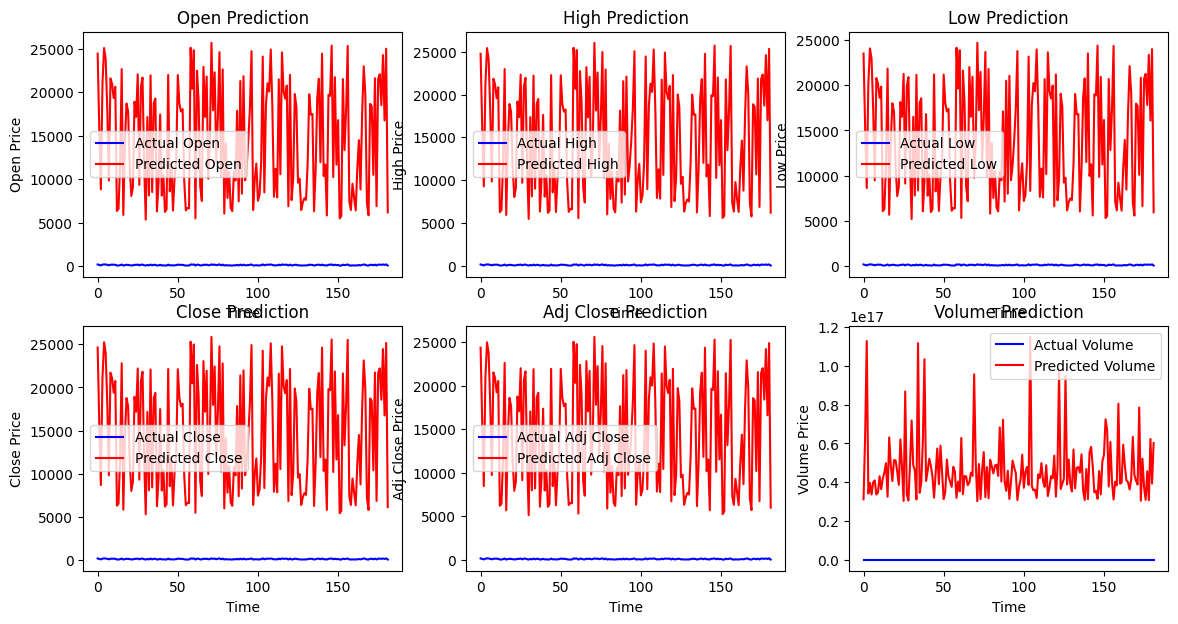

In [ ]:
# # plotting the results
# plt.figure(figsize=(14,7))

# for i, col in enumerate(df_scaled.columns):
#     plt.subplot(2,3,i+1)
#     plt.plot(y_test_rescaled[:,i], color = 'blue', label=f'Actual {col}')
#     plt.plot(predictions[:,i], color = 'red', label=f'Predicted {col}')
#     plt.title(f'{col} Prediction')
#     plt.xlabel('Time')
#     plt.ylabel(f'{col} Price')
#     plt.legend()
